In [26]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import getpass
import pymysql
import matplotlib

In [17]:
password = getpass.getpass()

database = 'geodata'
user = 'root'
host='localhost'

con = pymysql.connect(host=host, user=user, passwd=password, database=database)
cur = con.cursor()
con.autocommit(True)

 ·······


In [138]:
points = pd.read_sql("select code, responsible, water_body, year, count, mean, min, max, stddev, variance, ST_AsText(geometry) as geometry, state_initial from point", con)

points['geometry'] = points['geometry'].apply(wkt.loads)
points_gpd = gpd.GeoDataFrame(points, geometry="geometry")

points.head()
#points_gpd.plot()

,code,responsible,water_body,year,count,mean,min,max,stddev,variance,geometry,state_initial
0,00MS23CH2018,IMASUL,Rio Cachoeirão,2017,6,73.666667,70.6,75.3,2.377113,5.650667,POINT (-55.27222 -20.47750),MS
1,00MS23CN2002,IMASUL,Rio Canastrão,2017,6,70.166667,65.9,72.7,3.324254,11.050667,POINT (-55.11056 -20.64083),MS
2,00MS23MI0602,IMASUL,Rio Miranda,2017,6,71.633333,70.7,73.0,1.081974,1.170667,POINT (-56.12030 -21.48310),MS
3,00MS23MI1292,IMASUL,Rio Miranda,2017,6,63.166667,60.1,67.2,3.262310,10.642667,POINT (-56.39917 -20.24083),MS
4,00MS23MI2000,IMASUL,Rio Miranda,2017,6,70.000000,61.6,75.2,6.567800,43.136000,POINT (-57.33806 -19.42139),MS


         name                                           geometry fk_city_state
0      Aceguá  POLYGON ((-54.11276 -31.42931, -54.09821 -31.4...            RS
1  Água Santa  POLYGON ((-52.04263 -28.11703, -52.03489 -28.1...            RS
2       Agudo  POLYGON ((-53.25560 -29.44736, -53.23478 -29.4...            RS
3   Ajuricaba  POLYGON ((-53.78588 -28.11270, -53.78654 -28.1...            RS
4     Alecrim  POLYGON ((-54.78557 -27.57626, -54.77463 -27.5...            RS


<AxesSubplot:>

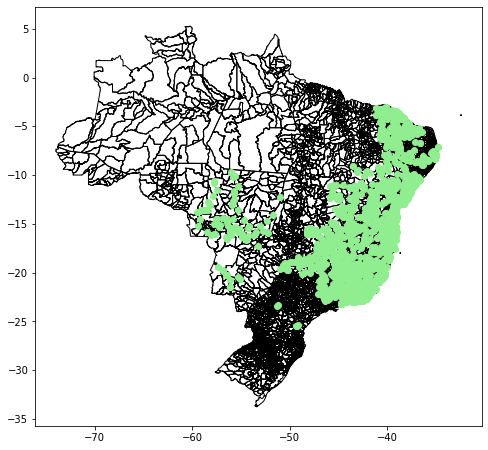

In [140]:
cities = pd.read_sql("select name,ST_AsText(geometry) as geometry,fk_city_state from city", con)
cities['geometry'] = cities['geometry'].apply(wkt.loads)
cities_gpd = gpd.GeoDataFrame(cities, geometry="geometry")
print(cities_gpd.head())

ax = cities_gpd.plot(color='none', figsize=(8,8))
points_gpd.plot(color='lightgreen',ax=ax)

In [151]:
rj = cities_gpd[cities_gpd['name']=="Vitória"]['geometry'].values[0]
points = points_gpd['geometry']
for point in points:
    if(rj.contains(point)):
       print(point)


POINT (-38.411139 -12.15905599961094)
POINT (-38.372778 -11.96027799961692)
